TODO:
Learn to use visualization techniques to study:
1. missing data
2. distributions
3. correlation heatmaps
4. pairplots,
5. t-SNE

pre-proc:
1. use catboost for categoric data

model: 


# JET House Prices Prediction 

# instruction
## Part 1:
[Model submission is done through Kaggle]
Part 1 - EDA
1. Which 3 features have the highest number of missing values
2. How the price behave over the years?
3. Plot the the feature distribution using histograms
4. Compute and order the features by their correlation with label
5. Add more EDA that will help you understand the data and support your modeling decisions

Part 2 - baseline
1. Train the simplest baseline model possible
2. submit your baseline results and share the results

## Part 2:
[Model submission is done through Kaggle]
Your solution:  go wild and build the best performing model!Which model you choose and why (relate to relevant EDA)?
Choose a validation creation process, why you choose it? what is the baseline performance?
Which smart tricks you used to boost your model performance?
Describe potential generalization issues (e.g. overfit/underfit)? How can you handle these?
submit your model and improve your rank in the leaderboard!

Deliverables
A final submission and score of you team in the leaderboard
Working and easy to follow notebook with the 3 parts completed and that produce your best submission.
Slides explaining your project: 
1. EDA
2. decision made
3. feature analysis
4. validation
5. modeling
6. etc



# Imports and loadings

In [1]:
#import tensorflow as tf
#import tensorflow_decision_forests as tfdf
import pandas as pd
import numpy as np
from scipy.stats import norm
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor
import warnings

warnings.filterwarnings('ignore')

# Comment this if the data visualisations doesn't work on your side
%matplotlib inline

# general functions

In [2]:
def printt(df,Name=None,verbose=True):    
    if verbose==True:
        print('----------------------')
        if Name!=None:
            print(Name)
        print(df)

In [3]:
def plot_perd(y, y_pred,verbose=True,addline = True):
    if verbose==True:
        plt.figure(figsize=(5, 5))
        plt.scatter(y, y_pred, color='blue')
        plt.title('True vs Predicted Values')
        plt.xlabel('True Values')
        plt.ylabel('Predicted Values')
        if addline: plt.plot([min(y), max(y)], [min(y), max(y)], color='red') # Line for perfect predictions
        plt.grid(True)
        plt.show()


# Load the dataset

In [4]:
test_file_path = "project/test.csv"
train_file_path = "project/train.csv"
testset_df = pd.read_csv(test_file_path)
dataset_df = pd.read_csv(train_file_path)
print("Full test set shape is {}".format(testset_df.shape))
print("Full train dataset shape is {}".format(dataset_df.shape))
id_file = testset_df['Id']
# Assuming 'dataset_df' is your DataFrame
y = dataset_df['SalePrice']
X = dataset_df.drop('SalePrice', axis=1)
# Splitting the dataset into training and testing sets
X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.2, random_state=42)

Full test set shape is (1459, 80)
Full train dataset shape is (1460, 81)


The data is composed of 81 columns and 1460 entries. We can see all 81 dimensions of our dataset by printing out the first 3 entries using the following code:

# EDA

## explain_feature

In [5]:
def explain_feature(feature_name, file_path="project/data_description.txt"):
    feature_name_lower = feature_name.lower()
    with open(file_path, "r") as file:
        lines = file.readlines()
        collecting = False
        for line in lines:
            if feature_name_lower in line.lower():
                collecting = True
            elif collecting and ":" in line and not line.lower().startswith(feature_name_lower):
                # If we're collecting and encounter a line with a colon that doesn't start with the feature name,
                # it's likely the start of another feature's description.
                break
            
            if collecting:
                print(line.strip())

# Example usage
explain_feature("MSSubClass")

MSSubClass: Identifies the type of dwelling involved in the sale.

20	1-STORY 1946 & NEWER ALL STYLES
30	1-STORY 1945 & OLDER
40	1-STORY W/FINISHED ATTIC ALL AGES
45	1-1/2 STORY - UNFINISHED ALL AGES
50	1-1/2 STORY FINISHED ALL AGES
60	2-STORY 1946 & NEWER
70	2-STORY 1945 & OLDER
75	2-1/2 STORY ALL AGES
80	SPLIT OR MULTI-LEVEL
85	SPLIT FOYER
90	DUPLEX - ALL STYLES AND AGES
120	1-STORY PUD (Planned Unit Development) - 1946 & NEWER
150	1-1/2 STORY PUD - ALL AGES
160	2-STORY PUD - 1946 & NEWER
180	PUD - MULTILEVEL - INCL SPLIT LEV/FOYER
190	2 FAMILY CONVERSION - ALL STYLES AND AGES



## categoric

In [6]:
def set_order_categoric_to_numeric(X,y=None,verbose=False):
# Assuming X is your DataFrame
 if 0:
    category_sets = [
        set(['Ex', 'Gd', 'TA', 'Fa', 'Po', 'NotExist']),
        set(['Gd', 'Av', 'Mn', 'No', 'NotExist']),
        set(['GLQ','ALQ','BLQ','Rec','LwQ','Unf','NotExist']),
        set(['Fin','RFn','Unf','NotExist']),
        set(['GdPrv','MnPrv','GdWo','MnWw','NotExist']),
    ]
    titles = ['quality_mapping', 'access_mapping', 'basement_mapping', 'garage_mapping', 'fence_mapping']
    
    # Mappings
    quality_mapping = {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NotExist': 0}
    access_mapping = {'Gd': 4, 'Av': 3, 'Mn': 2, 'No': 1, 'NotExist': 0}
    basement_mapping = {'GLQ': 6, 'ALQ': 5, 'BLQ': 4, 'Rec': 3, 'LwQ': 2, 'Unf': 1, 'NotExist': 0}
    garage_mapping = {'Fin': 3, 'RFn': 2, 'Unf': 1, 'NA': 0}
    fence_mapping = {'GdPrv': 4, 'MnPrv': 3, 'GdWo': 2, 'MnWw': 1, 'NotExist': 0}
    
    # Mapping from titles to actual mappings
    mapping_dict = {
        'quality_mapping': quality_mapping,
        'access_mapping': access_mapping,
        'basement_mapping': basement_mapping,
        'garage_mapping': garage_mapping,
        'fence_mapping': fence_mapping,
    }
    
    # Select columns of object type
    col_object = X.select_dtypes(include=['O']).columns.tolist()
    
    matching_categories = {}
    for col in col_object:
        vals = set(X[col].unique())
        # Check which category set vals belongs to
        for index, category_set in enumerate(category_sets):
            if vals.issubset(category_set):  # Check if all elements of vals are in the category_set
                matching_categories[col] = titles[index]                
                break  # Exit the loop if a matching set is found

    # Apply the matched mappings to the columns
    X_ = X.copy()
    for col, title in matching_categories.items():
        if title in mapping_dict:
            X_[col] = X[col].map(mapping_dict[title])

    if verbose==True:
        printt(len(matching_categories),'matching_categories')
        print(list(matching_categories.keys()))
        for col, title in matching_categories.items():
            if y is not None and not y.empty:
                categoric_analysis(X[[col]],y,True)
            print(f"{col}: {title} : {mapping_dict[title]}")
    
    return X_


----------------------
number of categorical
2
----------------------
categorical List
['MoSold', 'MSSubClass']
----------------------
MoSold

1
MoSold: Month Sold (MM)

       col  val ymean ystd  number ratio
0   MoSold    1 11.96 0.54      58  3.97
1   MoSold    4 11.97 0.39     141  9.66
2   MoSold    5 11.98 0.38     204 13.97
3   MoSold    6 12.02 0.36     253 17.33
4   MoSold   10 12.02 0.40      89  6.10
5   MoSold    3 12.03 0.41     106  7.26
6   MoSold    7 12.04 0.42     234 16.03
7   MoSold    2 12.05 0.29      52  3.56
8   MoSold    8 12.05 0.40     122  8.36
9   MoSold   12 12.06 0.40      59  4.04
10  MoSold   11 12.07 0.44      79  5.41
11  MoSold    9 12.10 0.42      63  4.32


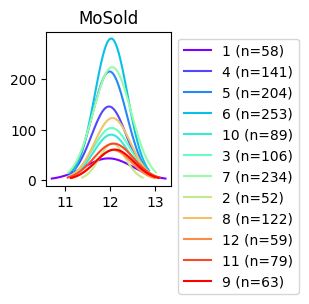

----------------------
MSSubClass

2
MSSubClass: Identifies the type of dwelling involved in the sale.

20	1-STORY 1946 & NEWER ALL STYLES
30	1-STORY 1945 & OLDER
40	1-STORY W/FINISHED ATTIC ALL AGES
45	1-1/2 STORY - UNFINISHED ALL AGES
50	1-1/2 STORY FINISHED ALL AGES
60	2-STORY 1946 & NEWER
70	2-STORY 1945 & OLDER
75	2-1/2 STORY ALL AGES
80	SPLIT OR MULTI-LEVEL
85	SPLIT FOYER
90	DUPLEX - ALL STYLES AND AGES
120	1-STORY PUD (Planned Unit Development) - 1946 & NEWER
150	1-1/2 STORY PUD - ALL AGES
160	2-STORY PUD - 1946 & NEWER
180	PUD - MULTILEVEL - INCL SPLIT LEV/FOYER
190	2 FAMILY CONVERSION - ALL STYLES AND AGES

           col  val ymean ystd  number ratio
0   MSSubClass   30 11.43 0.28      69  4.73
1   MSSubClass  180 11.50 0.25      10  0.68
2   MSSubClass   45 11.58 0.18      12  0.82
3   MSSubClass  190 11.73 0.28      30  2.05
4   MSSubClass   90 11.78 0.21      52  3.56
5   MSSubClass  160 11.81 0.26      63  4.32
6   MSSubClass   50 11.81 0.33     144  9.86
7   MSSubClass  

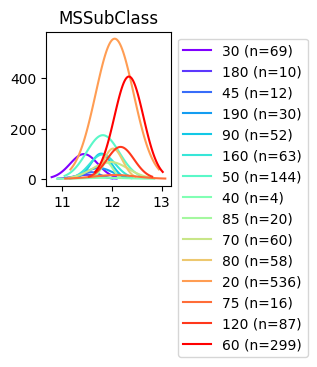

In [7]:
def categoric_analysis(X,y,verbose=False):
    #col_object = X.select_dtypes(include=['O']).columns.tolist()
    cols = X.columns.tolist()
    #cols = X.columns.tolist()
    printt(len(cols),'number of categorical',verbose=verbose)
    printt(cols,'categorical List',verbose=verbose)
    i=0
    for col in cols:
        i = i+1
        vals = X[col].unique()        
        cols = [col for _ in range(len(vals))]  # This will create a list with 'title' repeated
        #print('\n'.join(str(val) for val in vals))
        ymean  = [np.mean(np.log(y[X[col] == val]))  for val in vals]
        ystd   = [np.std(np.log(y[X[col] == val]))   for val in vals]
        ratios = [np.mean(X[col] == val)*100         for val in vals]
        numbers = [np.sum(X[col] == val)             for val in vals]

        df = pd.DataFrame({'col': cols, 'val': vals, 'ymean': ymean, 'ystd': ystd,'number': numbers, 'ratio': ratios})
        df.loc[pd.isna(vals), 'ratio'] = np.mean(X[col].isna())*100
        df.loc[pd.isna(vals), 'number'] = np.sum(X[col].isna())
        df.loc[pd.isna(vals), 'ymean'] = np.mean(np.log(y[X[col].isna()]))
        df.loc[pd.isna(vals), 'ystd'] = np.std(np.log(y[X[col].isna()]))
        df = df.sort_values(by='ymean', ascending=True).reset_index(drop=True)  # Use ascending=False for descending order
        # This will apply the formatting and then convert the DataFrame to a string for printing
        formatted_df_string = df.to_string(formatters={'ymean': "{:.2f}".format, 'ystd': "{:.2f}".format, 'ratio': "{:.2f}".format})
        printt('',col,verbose=verbose)      
        if verbose==True:        
            print(i)
            explain_feature(col)
            print(formatted_df_string)        
            plot_categoric(df,col)
    return df

def plot_categoric(df,col):
        ymean = df['ymean'].values
        ystd = df['ystd'].values
        numbers = df['number'].values
        vals = df['val'].values        
            # Plotting
        plt.figure(figsize=(2, 2))
        colors = plt.cm.rainbow(np.linspace(0, 1, len(vals)))  # Generate distinct colors

        for i, mean in enumerate(ymean):
            # Generate x values
            x = np.linspace(norm.ppf(0.01, loc=mean, scale=ystd[i]),
                            norm.ppf(0.99, loc=mean, scale=ystd[i]), 100)
            # Generate y values for Gaussian curve
            y_gauss = norm.pdf(x, loc=mean, scale=ystd[i]) * numbers[i]  # Scale by 'num'
            plt.plot(x, y_gauss, label=f'{vals[i]} (n={numbers[i]})', color=colors[i])

        plt.title(f'{col}')
        plt.legend()
        plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
        plt.subplots_adjust(right=0.75)
        plt.show()


#categoric_analysis(X[['ExterQual']],y,True)
#categoric_analysis(X[['Condition1']],y,True)
 
manual_feature_importance = {
    'not': ['Street','LandContour','Utilities','LotConfig','LandSlope','Condition2','RoofMatl','ExterCond','Heating','Functional','GarageQual','GarageCond','PavedDrive','PoolQC','Fence','MiscFeature'],
    'low': ['Alley','Condition1','BsmtCond','BsmtFinType2','CentralAir','Electrical'],
    'med': ['MSZoning','BldgType','HouseStyle','RoofStyle','Exterior1st','Exterior2nd','BsmtExposure','BsmtFinType1','SaleType','SaleCondition'],
    'high': ['LotShape','Neighborhood','MasVnrType','ExterQual','Foundation','BsmtQual','HeatingQC','KitchenQual','FireplaceQu','GarageType','GarageFinish']
}
#example of use
if 0:
    categoric_analysis(X[manual_feature_importance['not']],y,True)
if 0:
    df = categoric_analysis(X[['Neighborhood']],y,True)
if 1:
    df = categoric_analysis(X[['MoSold','MSSubClass']],y,True)

In [8]:
def categoric_to_numeric_maping(df,MinRatioPerGroup = 10 ,verbose=False):
    #df = pd.DataFrame({'col': cols, 'val': vals, 'ymean': ymean, 'ystd': ystd,'number': numbers, 'ratio': ratios})
    MinRatioPerGroup = 100/np.floor(100/MinRatioPerGroup)
    # diveide to groups
    sum_ratio = 0
    group = 0
    for i in range(len(df)):
        sum_ratio = sum_ratio + df.loc[i,'ratio']        
        df.loc[i,'group'] = group
        if sum_ratio>=MinRatioPerGroup:
           sum_ratio = 0
           group = group + 1        
    # add last group to prev if it's too small
    last_group_indexes = (df['group'] == group)
    if np.sum(df.loc[last_group_indexes,'ratio'])<MinRatioPerGroup:
        df.loc[last_group_indexes,'group'] = group-1

    # add last group to prev if it's too small
    if np.sum(df.loc[last_group_indexes,'ratio'])<MinRatioPerGroup:        
        df.loc[last_group_indexes,'group'] = group-1

    NGroups = int(df['group'].max()) + 1
    # calc mean y per group
    for g in range(NGroups):
        group_indexes = (df['group'] == g)
        ymean_group = np.sum(df.loc[group_indexes,'ymean']*df.loc[group_indexes,'number'])/np.sum(df.loc[group_indexes,'number'])
        df.loc[group_indexes,'ymean_group'] = ymean_group
        df.loc[group_indexes,'number_group'] = np.sum(df.loc[group_indexes,'number'])
        df.loc[group_indexes,'ratio_group'] = np.sum(df.loc[group_indexes,'ratio'])
    #print(df)
    val_to_ymean_map = df.set_index('val')['ymean_group'].to_dict()
    val_to_group_map = df.set_index('val')['group'].to_dict()
    return val_to_ymean_map,val_to_group_map

# Example usage:
# Assuming `df` is your DataFrame as shown in the image
def categoric_to_numeric_fit(X,y,categortic_config_params,cols=None, JustCategoric=True,verbose=False):
    MinRatioPerGroup = categortic_config_params['MinRatioPerGroup']
    if JustCategoric==True:
        exist_cols = X.select_dtypes(include=['O']).columns.tolist()
    else:
        exist_cols = X.columns.tolist()

    if cols is None:
        cols = exist_cols
    else:
        filtered_cols = [col for col in cols if col in exist_cols]
        cols = filtered_cols
    categoric_map = dict()
    for col in cols:
        df = categoric_analysis(X[[col]],y,False)
        val_to_ymean_map,val_togroup_map = categoric_to_numeric_maping(df,MinRatioPerGroup,verbose=verbose)        
        if categortic_config_params['replaceby']=='ymean':
            categoric_map[col] = val_to_ymean_map
        else:
            categoric_map[col] = val_togroup_map        
    return categoric_map
def categoric_to_numeric_transform(X,categoric_map,verbose=False):
    X_ = X.copy()
    for col in categoric_map:
        X_[col] = X_[col].map(categoric_map[col])        
    return X_

#ExampleOfuse
if 1:
    categortic_config_params1 = dict()
    categortic_config_params1['MinRatioPerGroup'] = 15
    categortic_config_params1['replaceby'] = 'ymean' #'ymean', 'group_nember'
    cols = manual_feature_importance['high']
    categoric_map = categoric_to_numeric_fit(X,y,categortic_config_params1,cols=cols,JustCategoric=True,verbose=False)
    X_numeric = categoric_to_numeric_transform(X,categoric_map,verbose=False)
    
    col_to_map_num = ['MoSold','MSSubClass']
    categoric_map_num = categoric_to_numeric_fit(X_numeric,y,categortic_config_params1,cols=col_to_map_num,JustCategoric=False,verbose=False)
    X_numeric = categoric_to_numeric_transform(X_numeric,categoric_map_num,verbose=False)
    
    col_object1 = X.select_dtypes(include=['O']).columns.tolist()
    col_object2 = X_numeric.select_dtypes(include=['O']).columns.tolist()
    print(len(col_object1),len(col_object2))


43 32


# Pre proccessing functions

## drop ID

In [9]:
# Custom transformer to remove NAs
class drop_ID(BaseEstimator, TransformerMixin):
    def __init__(self, verbose=False):        
        self.verbose = verbose
    def fit(self, X, y=None):
        printt('','In drop_ID fit',verbose=self.verbose)
        return self

    def transform(self, X, y=None):
        printt(X.shape,'drop_ID in X.shape',verbose=self.verbose)
        # Ensure 'Id' column is removed safely
        if 'Id' in X.columns:
            return X.drop('Id', axis=1)
        else:
            return X

## NAs

In [10]:
def imput_mean_mode(X,mean_mode):
    # impute missing value by pre calc mean or mode :
    col_numeric = X.select_dtypes(include=['float64', 'int64']).columns.tolist()
    col_object = X.select_dtypes(include=['O']).columns.tolist()
    # save the mean and the mode for later imputation
    combined_stats = pd.Series(dtype=object)
    for col in X.columns:        
        X[col].fillna(mean_mode[col], inplace=True)
    return X

In [11]:
def calc_mean_mode(X):
    # find the mean of numrical columns and the mode of object columns
    # return :
    # combined_stats = mean amd mode in the same shape as orign,
    # col_numeric,col_object =list of numeric and obkect coumln names
    col_numeric = X.select_dtypes(include=['float64', 'int64']).columns.tolist()
    col_object = X.select_dtypes(include=['O']).columns.tolist()
    printt(col_numeric,'col_numeric',False)
    printt(col_object,'col_object',False)
    # save the mean and the mode for later imputation
    means = X[col_numeric].mean()
    modes = X[col_object].mode().iloc[0]
    # Step 3: Combine results, maintaining the original arrangement
    combined_stats = pd.Series(dtype=object)
    for col in X.columns:
        if col in means:
            combined_stats[col] = means[col]
        elif col in modes:
            combined_stats[col] = modes[col]
    return combined_stats,col_numeric,col_object

In [12]:
def find_bad_col(X,threshold=None,verbose=False):
    # drop col with na in amount more than threshold
    if threshold is not None:
        thresh = len(X)*threshold//1        
        na_counts    = X.isna().sum()
        columns_to_keep_ = na_counts[na_counts < thresh].index
        columns_to_remove_ = na_counts[na_counts >= thresh].index
    else:
        columns_to_keep_ = X.columns
        columns_to_remove_ = pd.Index([])        

    if verbose==True:
        nan_counts  = X.isna().sum().sort_values(ascending=False).head(20)/len(X)*100
        print(f"features with the highest number of missing values in %")
        print(f"{nan_counts}%")
        printt(len(columns_to_keep_),'len(columns_to_keep_)',verbose=verbose)
        printt(len(columns_to_remove_),'len(columns_to_remove_)',verbose=verbose)
        if len(columns_to_remove_)>0:
            printt(columns_to_remove_,'columns_to_remove_',verbose=verbose)           

    return columns_to_keep_,columns_to_remove_


In [13]:
def print_row_nan_counts(X,verbose=False):
    # print number of Rows with missing values
    row_nan_counts = X.isna().sum(axis=1) 
    top_row_nan_counts = row_nan_counts.sort_values(ascending=False)
    if verbose==True:
        print("number of Rows with missing values:")
        print(top_row_nan_counts.value_counts())


In [14]:
def print_missingVal_groups(X,verbose=False):
    row_nan_counts = X.isna().sum(axis=1) 
    rows_with_missing_values = X[row_nan_counts >0]
    unique_missing_column_groups = set()
    # Iterate through rows and identify unique groups of missing columns
    for _, row in rows_with_missing_values.iterrows():
        # Extract groups of 5 columns
        groups = tuple(row.index[row.isna()])
        # Add the unique group to the set
        unique_missing_column_groups.add(groups)
    
    # Sort the unique groups by their length
    sorted_unique_missing_column_groups = sorted(unique_missing_column_groups, key=lambda x: len(x))
    # Print the unique groups of 5 missing columns
    if verbose==True:
        print('\nmissing values groups:')
        for i, group in enumerate(sorted_unique_missing_column_groups, start=1):
            print(f"Group {i} of {len(group)} missing columns: {group}")

In [15]:
class remove_NAs_col(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=None,verbose=False):        
        self.threshold = threshold  # Minimum non-NA values required to keep a column
        self.verbose = verbose
    def fit(self, X, y=None):
        printt('','In RemoveNAs Col fit',verbose=self.verbose)
        # If threshold is set, identify columns to keep based on the threshold
        self.columns_to_keep_,self.columns_to_remove_ = find_bad_col(X,self.threshold,self.verbose)
        return self
    
    def transform(self, X, y=None):
        printt('','In RemoveNAs Col transform',verbose=self.verbose)
        # Drop columns not meeting the threshold requirement
        printt(X.shape,'X.shape',verbose=self.verbose)
        X_transformed = X.loc[:, self.columns_to_keep_]
        printt(X_transformed.shape,'X_transformed.shape',verbose=self.verbose)        
        return X_transformed

In [16]:
class imput_NAs_row(BaseEstimator, TransformerMixin):
    def __init__(self, verbose=False):        
        self.column_means_ = None
        self.verbose = verbose
        self.col_numeric = None
        self.col_object = None
    def fit(self, X, y=None):
        printt('','In imput_NAs_row fit',verbose=self.verbose)
        # Calculate mean values for each column, ignoring NA's
        printt(X.shape,'imput_NAs_row in X.shape',verbose=self.verbose)
        # save the mean and the mode for later imputation
        self.mean_mode,self.col_numeric,self.col_object = calc_mean_mode(X)
        print_row_nan_counts(X,verbose=self.verbose)
        print_missingVal_groups(X,verbose=self.verbose)        
        return self
    
    def transform(self, X, y=None):
        printt('','In imput_NAs_row transform',verbose=self.verbose)
        printt(X.shape,'X.shape',verbose=self.verbose)
        print_row_nan_counts(X,verbose=self.verbose)

        printt('','filing Garage and Bsmt',verbose=self.verbose)
        # Replace NaN values in the specified columns for rows where 'TotalBsmtSF' is equal to 0 with 'NotExist'
        basement_list = ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']
        Garage_list = ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']
        X.loc[X['TotalBsmtSF'] == 0, basement_list] = X.loc[X['TotalBsmtSF'] == 0, basement_list].fillna('NotExist')
        X.loc[X['GarageArea'] == 0, Garage_list] = X.loc[X['GarageArea'] == 0, Garage_list].fillna('NotExist')
        print_row_nan_counts(X,verbose=self.verbose)
        # special imputation
        printt('','special imputation',verbose=self.verbose)
        X['GarageYrBlt'].fillna(X['YearBuilt'], inplace=True)        
        X['BsmtFinType2'].fillna('NotExist', inplace=True)
        X['BsmtExposure'].fillna('NotExist', inplace=True)
        print_row_nan_counts(X,verbose=self.verbose)

        printt('','imput_mean_mode',verbose=self.verbose)
        X = imput_mean_mode(X,self.mean_mode)
        print_row_nan_counts(X,verbose=self.verbose)
        return X

## handle categorical

In [17]:
def replace_qual_categoric(X,y=None,verbose=False):
# Assuming X is your DataFrame

    category_sets = [
        set(['Ex', 'Gd', 'TA', 'Fa', 'Po', 'NotExist']),
        set(['Gd', 'Av', 'Mn', 'No', 'NotExist']),
        set(['GLQ','ALQ','BLQ','Rec','LwQ','Unf','NotExist']),
        set(['Fin','RFn','Unf','NotExist']),
        set(['GdPrv','MnPrv','GdWo','MnWw','NotExist']),
    ]
    titles = ['quality_mapping', 'access_mapping', 'basement_mapping', 'garage_mapping', 'fence_mapping']
    
    # Mappings
    quality_mapping = {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NotExist': 0}
    access_mapping = {'Gd': 4, 'Av': 3, 'Mn': 2, 'No': 1, 'NotExist': 0}
    basement_mapping = {'GLQ': 6, 'ALQ': 5, 'BLQ': 4, 'Rec': 3, 'LwQ': 2, 'Unf': 1, 'NotExist': 0}
    garage_mapping = {'Fin': 3, 'RFn': 2, 'Unf': 1, 'NA': 0}
    fence_mapping = {'GdPrv': 4, 'MnPrv': 3, 'GdWo': 2, 'MnWw': 1, 'NotExist': 0}
    
    # Mapping from titles to actual mappings
    mapping_dict = {
        'quality_mapping': quality_mapping,
        'access_mapping': access_mapping,
        'basement_mapping': basement_mapping,
        'garage_mapping': garage_mapping,
        'fence_mapping': fence_mapping,
    }
    
    # Select columns of object type
    col_object = X.select_dtypes(include=['O']).columns.tolist()
    
    matching_categories = {}
    for col in col_object:
        vals = set(X[col].unique())
        # Check which category set vals belongs to
        for index, category_set in enumerate(category_sets):
            if vals.issubset(category_set):  # Check if all elements of vals are in the category_set
                matching_categories[col] = titles[index]                
                break  # Exit the loop if a matching set is found

    # Apply the matched mappings to the columns
    X_ = X.copy()
    for col, title in matching_categories.items():
        if title in mapping_dict:
            X_[col] = X[col].map(mapping_dict[title])

    if verbose==True:
        printt(len(matching_categories),'matching_categories')
        print(list(matching_categories.keys()))
        for col, title in matching_categories.items():
            if y is not None and not y.empty:
                categoric_analysis(X[[col]],y,True)
            print(f"{col}: {title} : {mapping_dict[title]}")
    
    return X_

#replace_qual_categoric()
def print_features(X,y,col_list=None): 
    if col_list is None:
        col_list = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 'KitchenQual', 'GarageFinish', 'GarageQual', 'GarageCond']
    columns_to_keep_,columns_to_remove_ = find_bad_col(X,.15)
    Xnew = X.loc[:, columns_to_keep_]
    print(Xnew.shape)
    imp = imput_NAs_row()
    imp.fit(Xnew)
    Xnew = imp.transform(Xnew)
    print(Xnew.shape)
    X_ = replace_qual_categoric(Xnew[col_list],y,verbose=True)
    Xnew.shape,X_.shape

if 0:
    print_features(X,y)

In [23]:
class handle_categoric(BaseEstimator, TransformerMixin):
    def __init__(self,categortic_config_params,verbose=False,col_to_map=None):        
        self.col_numeric = None
        self.verbose = verbose
        self.col_object = None
        self.col_to_map_num = ['MoSold','MSSubClass']
        self.categoric_map_num = None
        self.categortic_config_params = categortic_config_params
    def fit(self, X, y=None):
        printt('','In categoric fit',verbose=self.verbose)
        self.col_numeric = X.select_dtypes(include=['float64', 'int64']).columns.tolist()
        self.col_object = X.select_dtypes(include=['O']).columns.tolist()
        #col_to_map = manual_feature_importance['high']
        col_to_map = self.col_object
        self.categoric_map  = categoric_to_numeric_fit(X,y,self.categortic_config_params,cols=col_to_map,JustCategoric=True,verbose=self.verbose)
        self.categoric_map_num = categoric_to_numeric_fit(X_numeric,y,categortic_config_params1,cols=self.col_to_map_num,JustCategoric=False,verbose=False)


        
        return self
    
    def transform(self, X):
        # for now remove all categoric TODO: improve this
        printt('','In categoric transform',verbose=self.verbose)
        printt(X.shape,'X.shape',verbose=self.verbose)

        if self.categortic_config_params['drop_categoric']=='KeepJustOrdered' :
            X = replace_qual_categoric(X,verbose=self.verbose)
            col_numeric = X.select_dtypes(include=['float64', 'int64']).columns.tolist()
            left_objects = len(X.select_dtypes(include=['O']).columns.tolist())
            printt('',f'number of num feature befor {len(self.col_numeric)}, added {len(col_numeric) - len(self.col_numeric)}, left_objects: {left_objects}',verbose=self.verbose)
            X = X.loc[:, col_numeric]

        if self.categortic_config_params['drop_categoric'] == 'TransformAll':         
            X = categoric_to_numeric_transform(X,self.categoric_map,verbose=self.verbose)
            X = categoric_to_numeric_transform(X,self.categoric_map_num,verbose=self.verbose)
            col_numeric = X.select_dtypes(include=['float64', 'int64']).columns.tolist()
            X = X.loc[:, col_numeric]            
            
        if self.categortic_config_params['drop_categoric'] =='DropAll':
            col_numeric = X.select_dtypes(include=['float64', 'int64']).columns.tolist()
            X = X.loc[:, col_numeric]

        #printt(len(X.select_dtypes(include=['O']).columns.tolist()),'length Object')
        #print(X.select_dtypes(include=['O']).columns.tolist())
        return X

## terget_manipulation

In [24]:
def terget_manipulation(y,take_log_target=0,verbose=False):      
        if take_log_target==0:                                    
            if verbose==True:
                print('no log on target')
            return y
        if take_log_target==1:                        
            if verbose==True:
                print('take log on target')
            return np.log(y)
        if take_log_target==-1:                        
            if verbose==True:
                print('un-do log on target')
            return np.exp(y)

# Config params

In [25]:
categortic_config_params = dict()
categortic_config_params['MinRatioPerGroup'] = 10
categortic_config_params['replaceby'] = 'ymean' #'ymean', 'group_nember'
#categortic_config_params['categoric_to_replace'] ='just_high' # 'All','from_low_to_high','from_med_to_high','just_high'
categortic_config_params['drop_categoric'] = 'TransformAll' #'KeepAll','KeepJustOrdered','TransformAll','DropAll', KeepAll is the best option

Config_params = dict()
Config_params['nan_counts_threshold'] = .15
Config_params['filter_out_HighNA'] = 1
Config_params["model"]='decisionTree' #'decisionTree','CatBoost', CatBoost is the best option
Config_params["take_log_target"] = 1 # 0,1  . 1 is the best option
Config_params["verbose"]=False # False,True
Config_params["categortic_config_params"] = categortic_config_params



# pipeline

In [26]:
# Function to create and return a pipeline based on the configuration
def create_pipeline(config_params):
    verbose = Config_params["verbose"]
    categortic_config_params = config_params["categortic_config_params"]

    # Dynamically select the model based on config_params
    printt(Config_params['model'],'Model',verbose=verbose)
    if config_params['model'] == 'DecisionTree':
        model = DecisionTreeRegressor(random_state=42)
    elif config_params['model'] == 'CatBoost':
        #
        if categortic_config_params['drop_categoric'] == 'KeepAll':
            categorical_columns = X.select_dtypes(include=['O']).columns.tolist()
            categorical_columns = ['MSZoning', 'Street', 'LotShape', 'LandContour',
                               'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood',
                               'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
                               'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd',
                               'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
                               'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
                               'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
                               'Functional', 'GarageType', 'GarageFinish', 'GarageQual',
                               'GarageCond', 'PavedDrive', 'SaleType', 'SaleCondition']
            model = CatBoostRegressor(random_seed=42, silent=True, cat_features = categorical_columns)
        else:
            model = CatBoostRegressor(random_state=42, verbose=int(verbose))  # Adjust verbosity for CatBoost
        #printt(len(categorical_columns),'length categorical_columns')
        #print(categorical_columns)
        
    pipeline = Pipeline([
        ('drop_ID', drop_ID(verbose=verbose)),
        ('remove_nas_col', remove_NAs_col(threshold=config_params['nan_counts_threshold'], verbose=verbose)),
        ('imput_nas_row', imput_NAs_row(verbose=verbose)),
        ('handle_categoric', handle_categoric(categortic_config_params,verbose=verbose)),
        ('reg', model)  # Use the dynamically selected model
    ])
    
    return pipeline


Pipeline created for model: CatBoost, drop_categoric: DropAll
logRMS = 0.13860
Pipeline created for model: CatBoost, drop_categoric: TransformAll
logRMS = 0.13224
Pipeline created for model: CatBoost, drop_categoric: KeepAll
logRMS = 0.13107


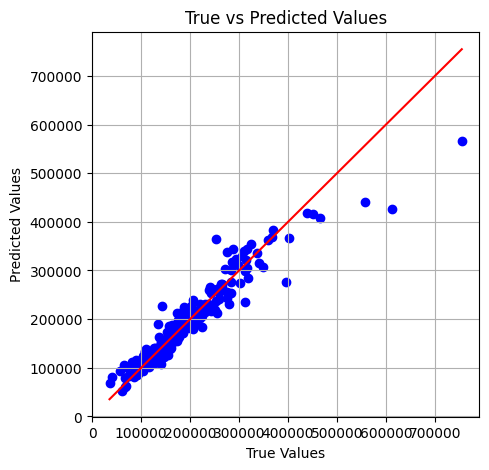

In [28]:
# Iterate over all combinations
models = ['CatBoost'] #['DecisionTree', 'CatBoost']
drop_categoric_options = ['DropAll','TransformAll','KeepAll'] #'KeepAll','KeepJustOrdered','DropAll','TransformAll'

i=0
pipelines = {}
for model in models:
    for drop_categoric in drop_categoric_options:
            Config_params["model"] = model
            Config_params["drop_categoric"] = drop_categoric
            Config_params["categortic_config_params"] = {**categortic_config_params, "drop_categoric": drop_categoric}
            pipeline = create_pipeline(Config_params)
            print(f"Pipeline created for model: {model}, drop_categoric: {drop_categoric}")
            # Add your code here to train the pipeline or to print further details
    
            new_y = terget_manipulation(y_train,take_log_target=Config_params['take_log_target'])
    
            pipeline.fit(X_train,new_y)
            y_pred = pipeline.predict(X_validation)
    
            y_pred = terget_manipulation(y_pred,take_log_target=-1*Config_params['take_log_target'],verbose=Config_params["verbose"])
            # check errors             
            rms_log = np.sqrt(mean_squared_error(np.log(y_validation), np.log(y_pred)))        
            print(f"logRMS = {rms_log:.5f}")
            pipelines[i] = pipeline
            i=i+1     

if 0: print('\n'.join(f"{col}: {title}" for col, title in Config_params.items()))

plot_perd(y_validation, y_pred,True)


In [32]:
pipeline

AttributeError: 'handle_categoric' object has no attribute 'col_to_map'

AttributeError: 'handle_categoric' object has no attribute 'col_to_map'

AttributeError: 'handle_categoric' object has no attribute 'col_to_map'

# Post Proccessing

----------------------
top_names
['GrLivArea' 'OverallQual' 'Neighborhood' 'TotalBsmtSF' 'LotArea'
 '1stFlrSF' 'Fireplaces' 'BsmtFinSF1']


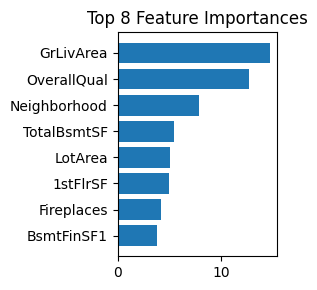

----------------------
top_names
['OverallQual' 'GrLivArea' 'TotalBsmtSF' 'KitchenQual' 'LotArea'
 'GarageCars' 'Fireplaces' 'BsmtQual']


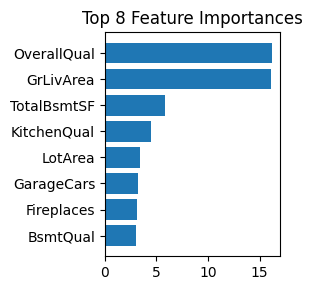

In [30]:
def Post_Proccessing(pipeline):
    model = pipeline.named_steps['reg']
    
    # Step 3: Get Feature Importances
    feature_importances = model.get_feature_importance()
    feature_names = model.feature_names_
    sorted_indices = np.argsort(feature_importances)[::-1]
    
    # Limit to first 8 features
    top_indices = sorted_indices[:8]
    top_importances = feature_importances[top_indices]
    top_names = np.array(feature_names)[top_indices]

    printt(top_names,'top_names')
    #print_features(X,y,top_names)
    # Plot
    plt.figure(figsize=(3, 3))
    plt.title("Top 8 Feature Importances")
    plt.barh(range(len(top_importances)), top_importances, align="center")
    plt.yticks(range(len(top_importances)), top_names)
    plt.gca().invert_yaxis()  # Invert y-axis to have the feature with the highest importance on top
    plt.tight_layout()
    plt.show()

def Post_Proccessing_shap(pipeline):
    model = pipeline.named_steps['reg']

    # Calculate SHAP values
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_train)
    
    # Summarize the effects of all the features
    shap.summary_plot(shap_values, X_train, plot_type="bar")

Post_Proccessing(pipelines[1])
Post_Proccessing(pipelines[2])


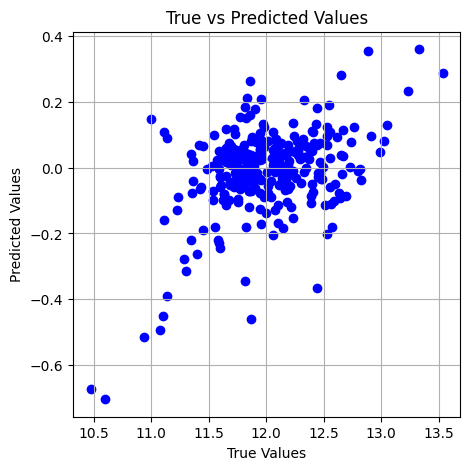

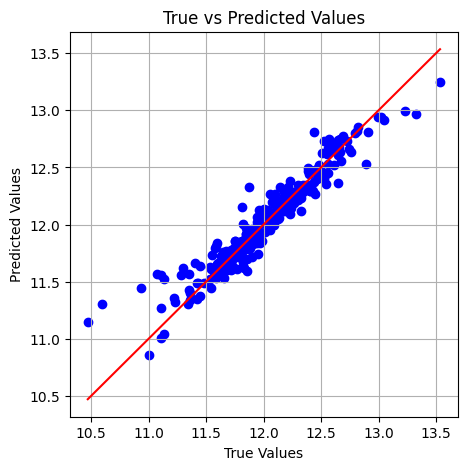

In [31]:
plot_perd(np.log(y_validation),np.log(y_validation)-np.log(y_pred),True,addline=False)
plot_perd(np.log(y_validation),np.log(y_pred),True,addline=True)


# Submission
Finally predict on the competition test data using the model.

In [ ]:
# fit again now on full data_set to improve results
y_new = terget_manipulation(y,take_log_target=Config_params['take_log_target'])
pipeline.fit(X,y_new)
# predinct on test
y_pred = pipeline.predict(testset_df)
y_pred = terget_manipulation(y_pred,take_log_target=-1*Config_params['take_log_target'])
 
output = pd.DataFrame({'Id': id_file,
                       'SalePrice': y_pred.squeeze()})
# create CSV
output.to_csv('./project/submission.csv', index=False)
output.head()